In [1]:
pip install numpy pandas scikit-learn tensorflow matplotlib

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: /srv/jupyter/python-venv/bin/python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Reshape
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error
from datetime import timedelta


2024-10-08 15:35:40.280183: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-08 15:35:40.310243: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 15:35:40.316248: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-08 15:35:40.328049: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-08 15:35:40.346853: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [5]:
# Load the weather data (this will be 366 enteris)
data = pd.read_csv('combined_weather_data.csv')
n = 1000
data = data.tail(n)

# Convert the Year, Month, Day columns into a single datetime column
data['date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.set_index('date', inplace=True)
data.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Select features for prediction
features = ['Min Temp', 'Max Temp', 'Humidity', 'Pressure', 'Precipitation']
data = data[features]

# Scale the data between 0 and 1
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)
scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)

# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(scaled_df) * 0.8)
train_data = scaled_df[:train_size]
test_data = scaled_df[train_size:]

# Create sequences
def create_sequences(data, sequence_length, prediction_length):
    sequences = []
    labels = []
    for i in range(len(data) - sequence_length - prediction_length + 1):
        seq = data.iloc[i:i + sequence_length].values
        label = data.iloc[i + sequence_length: i + sequence_length + prediction_length].values
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)

# Define sequence and prediction lengths
sequence_length = n // 10  # Input sequence 
prediction_length = 1  # Predict the next 

# Create sequences for training and testing
X_train, y_train = create_sequences(train_data, sequence_length, prediction_length)
X_test, y_test = create_sequences(test_data, sequence_length, prediction_length)

# Ensure the data type is float32
X_train = X_train.astype(np.float32)
y_train = y_train.astype(np.float32)
X_test = X_test.astype(np.float32)
y_test = y_test.astype(np.float32)

# Check the shape of the generated sequences and labels
print("X_train shape:", X_train.shape)  # Should be (samples, sequence_length, num_features)
print("y_train shape:", y_train.shape)  # Should be (samples, prediction_length, num_features)

# Load the trained model
model = load_model('best_model.keras')

# Compile the model with a lower learning rate (e.g., 0.0005)
model.compile(optimizer=Adam(learning_rate=0.00005), loss='mean_squared_error')

# Set up callbacks for early stopping and model checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model1.keras', save_best_only=True)

# Train the model and save the history
history = model.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_test, y_test), callbacks=[early_stopping, model_checkpoint])

X_train shape: (700, 100, 5)
y_train shape: (700, 1, 5)
Epoch 1/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 0.0639 - val_loss: 0.0610
Epoch 2/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0433 - val_loss: 0.0529
Epoch 3/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0338 - val_loss: 0.0454
Epoch 4/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0279 - val_loss: 0.0348
Epoch 5/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0228 - val_loss: 0.0264
Epoch 6/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0210 - val_loss: 0.0215
Epoch 7/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0179 - val_loss: 0.0183
Epoch 8/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 116ms/step - loss: 0.0158 - val_loss: 0.0169
Epoch 9/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 117ms/step - loss: 0.0149 - val_loss: 0.0146
Epoch 10/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 118ms/step - loss: 0.0139 - val_loss: 0.0137
Epoch 11/100
44/44 ━━━━━━━━━━━━━━━━━━━━ 5s 121ms/step - loss: 0.0132 - va

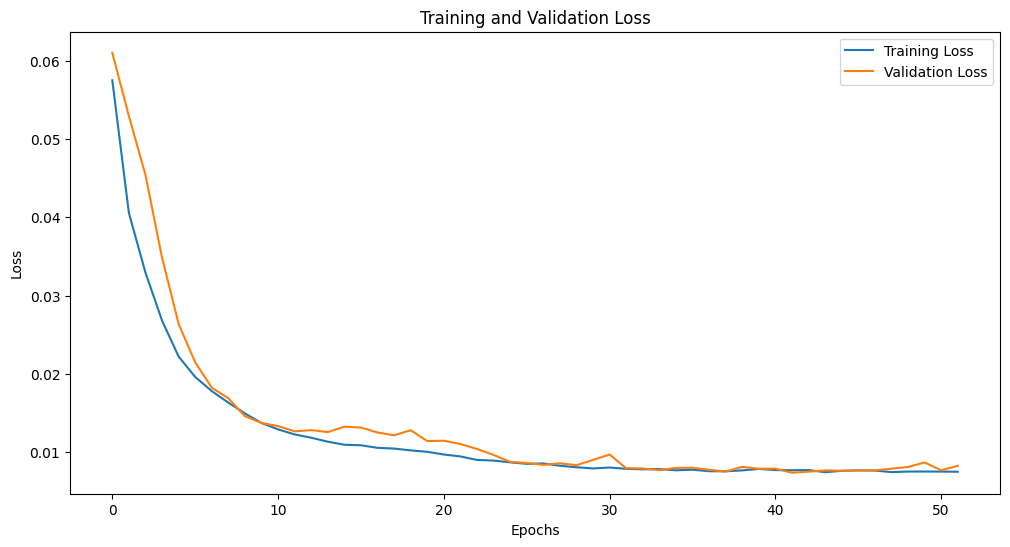

In [6]:
# Plot the training and validation loss
plt.figure(figsize=(12, 6))  # Optional: Set figure size
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# Load the weather data
data = pd.read_csv('combined_weather_data.csv')

# Convert Year, Month, Day columns into a single datetime column
data['date'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.set_index('date', inplace=True)
data.drop(columns=['Year', 'Month', 'Day'], inplace=True)

# Select features for prediction
features = ['Min Temp', 'Max Temp', 'Humidity', 'Pressure', 'Precipitation']
data = data[features]

# Scale the data using used scaler
scaled_data = scaler.transform(data)  # Fit the scaler on the entire dataset
scaled_df = pd.DataFrame(scaled_data, columns=features, index=data.index)

# Define sequence length
sequence_length = 366  # Input sequence 

# Use the entire scaled data for prediction
last_sequence = scaled_df.values[-sequence_length:].reshape(1, sequence_length, len(features))  # Ensure correct shape

# Load the trained model
model = load_model('best_model1.keras')

# Predict future weather for the next 366 days
future_prediction = model.predict(last_sequence)

# Reshape the predicted data to 2D for inverse transformation
future_prediction_reshaped = future_prediction.reshape(future_prediction.shape[1], future_prediction.shape[2])

# Inverse transform the prediction back to the original scale
future_weather = scaler.inverse_transform(future_prediction_reshaped)

# Print the predicted future weather
print(f"Predicted future weather for the next {len(future_weather)} days: \n{future_weather}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step
Predicted future weather for the next 366 days: 
[[  26.97241    31.867653   81.53249  1007.23004    12.312943]
 [  27.034658   31.891249   81.40257  1007.3499     12.516735]
 [  27.039469   31.8766     81.537544 1007.3529     12.737556]
 ...
 [  27.01864    32.009224   80.78616  1007.2028     12.362082]
 [  27.010273   32.064213   80.68235  1007.2413     12.097842]
 [  27.019466   32.064915   80.574326 1007.1965     11.980656]]


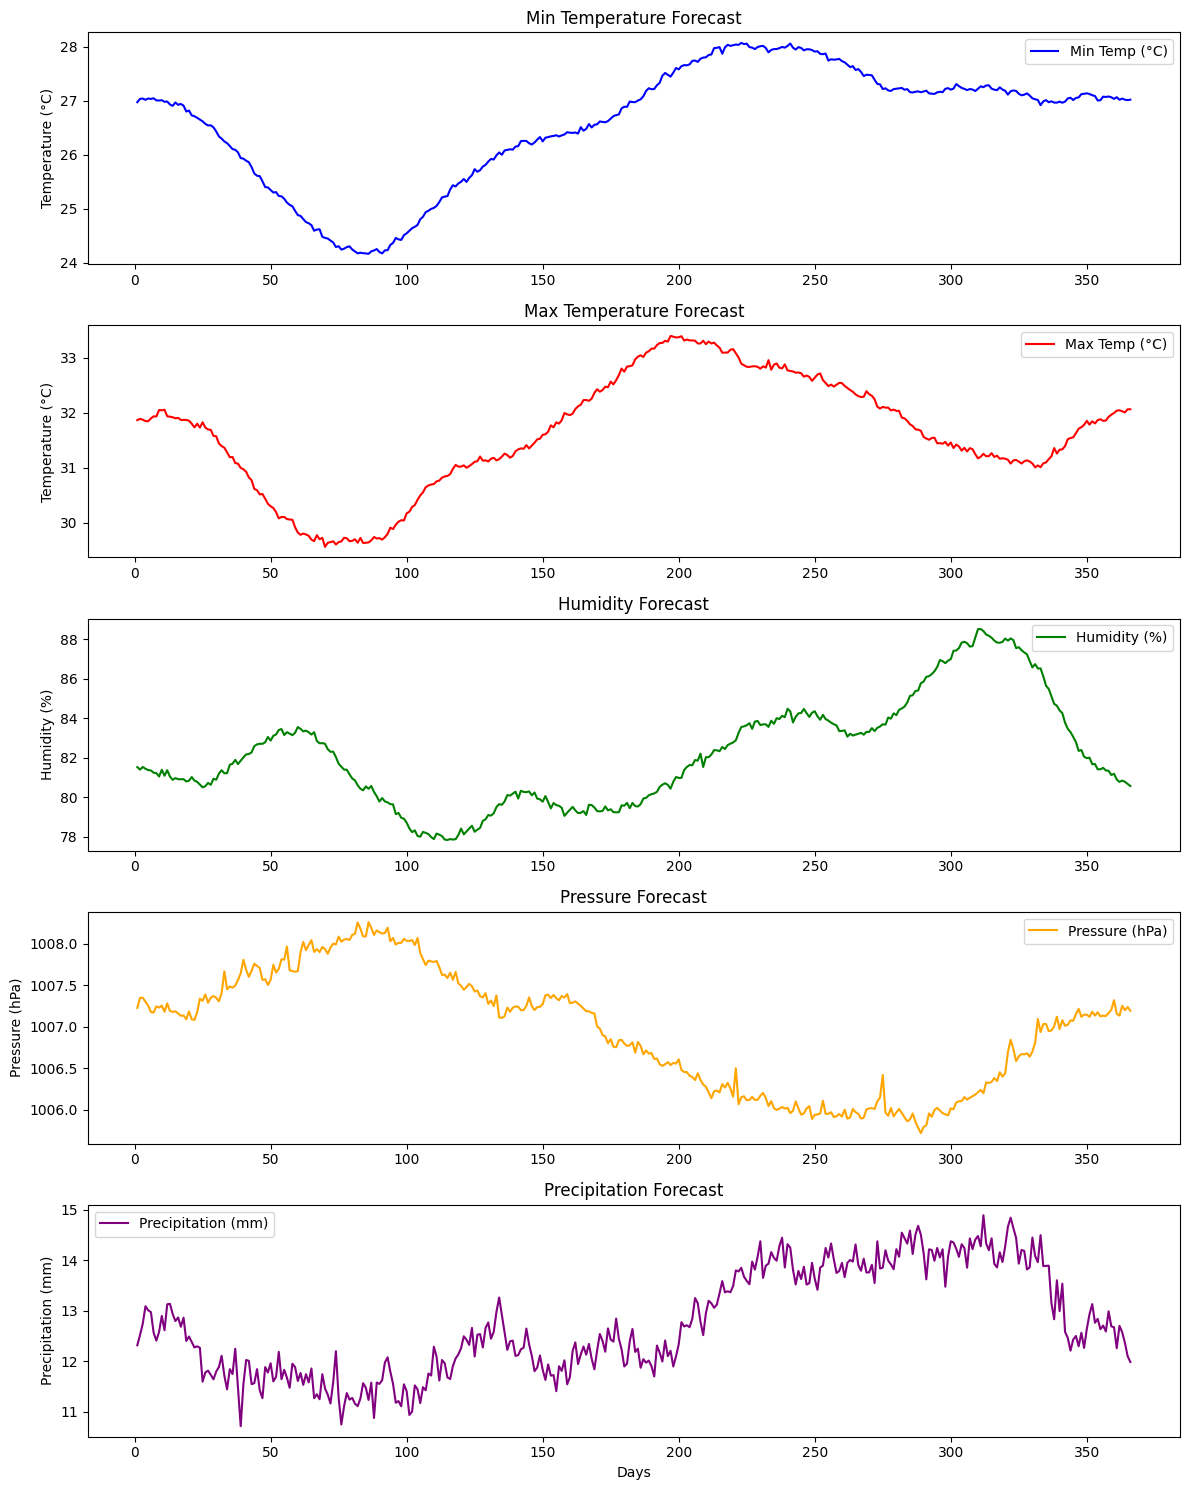

In [13]:
days = np.arange(1, len(future_weather) + 1)

# Extracting each weather feature
min_temp = future_weather[:, 0]   # First column for Min Temp
max_temp = future_weather[:, 1]   # Second column for Max Temp
humidity = future_weather[:, 2]   # Third column for Humidity
pressure = future_weather[:, 3]   # Fourth column for Pressure
precipitation = future_weather[:, 4]  # Fifth column for Precipitation

# Creating individual plots for each weather feature
plt.figure(figsize=(12, 15))

# Plot for Min Temperature
plt.subplot(5, 1, 1)
plt.plot(days, min_temp, label='Min Temp (°C)', color='blue')
plt.title('Min Temperature Forecast')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot for Max Temperature
plt.subplot(5, 1, 2)
plt.plot(days, max_temp, label='Max Temp (°C)', color='red')
plt.title('Max Temperature Forecast')
plt.ylabel('Temperature (°C)')
plt.legend()

# Plot for Humidity
plt.subplot(5, 1, 3)
plt.plot(days, humidity, label='Humidity (%)', color='green')
plt.title('Humidity Forecast')
plt.ylabel('Humidity (%)')
plt.legend()

# Plot for Pressure
plt.subplot(5, 1, 4)
plt.plot(days, pressure, label='Pressure (hPa)', color='orange')
plt.title('Pressure Forecast')
plt.ylabel('Pressure (hPa)')
plt.legend()

# Plot for Precipitation
plt.subplot(5, 1, 5)
plt.plot(days, precipitation, label='Precipitation (mm)', color='purple')
plt.title('Precipitation Forecast')
plt.ylabel('Precipitation (mm)')
plt.xlabel('Days')
plt.legend()

plt.tight_layout()  # Adjust subplots to fit into the figure area
plt.show()